## Denoising and Detoning

### 1. Motivation

공분산 행렬은 금융 어디에서나 존재한다. 경험적 공분산 행렬은 랜덤 벡터를 구성하는 랜덤 변수 사이의 선형 결합을 추정하고자 랜덤 벡터의 일련의 관측값에 대해 계산된다. 이러한 관측값의 유한성과 비결정론적 특성을 고려할 때 공분산 행렬의 추정값에는 일정량의 잡음이 포함되어 있다

금융시장 분석에 있어서 factor들은 이러한 불안정한 공분산으로부터 추정되었기 떄문에 추정된 공분산은 필연적으로 불량 조건 하에 있게 된다. 이 잡음을 처리하지 않는 한 공분산 행렬로 수행하는 계산에 영향을 미칠 수 있으며, 때로는 분석을 무용지물로 만들 수도 있다

이번 장에서는 공분산 행렬에서의 잡음을 줄이고, 경험적 공분산 행렬에 포함된 신호를 개선하도록 한다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.utils.stats import *
from FinancialMachineLearning.machine_learning.clustering import *

### 2. The Marcenko-Pastur Theorem

관측값을 생성하는 기본 프로세스의 평균 0과 분산 $\sigma^2$인 독립적이고 동일하게 분포된 랜덤 관측값 X의 행렬을 고려하자. 행렬 $C = T^{-1}X^\prime X$는 Marcenko-Pastur Probability Density Function으로 점근적으로 수렴하는 고유값을 가진다

$$f(\lambda) = \begin{cases}
\frac{T}{N} \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2 \pi \lambda \sigma^2}, & \mbox{     if }\lambda \in [\lambda_-, \lambda_+] \\
0, & \mbox{     if }\lambda \notin [\lambda_-, \lambda_+]
\end{cases}$$

여기서 최대 기대 고유값은 $\lambda_+ = \sigma^2(1 + \sqrt{N/T})^2$이고, 최소 기대 고유값은 $\lambda_- = \sigma^2 (1-\sqrt{N/T})^2$이다. $\sigma^2 = 1$일 때 $C$는 $X$와 연관된 상관 행렬이다. 

아래와 같이 Marcenko-Pastur 분포가 Random Matrix의 고유값을 얼마나 근접하게 설명하는지 보여 준다

잡음만 존재하는 경험적 랜덤 행렬 분포의 고유값을 marcenko-pastur dist에 적합화한 경우

In [2]:
x = np.random.normal(size = (10000, 1000))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar = 0))
pdf0 = marcenko_pastur_prob_distribution(1.0, q = x.shape[0] / float(x.shape[1]), pts = 1000)
pdf1 = fit_kde(
    np.diag(eVal0),
    bWidth = .01
) # empirical prob. dist

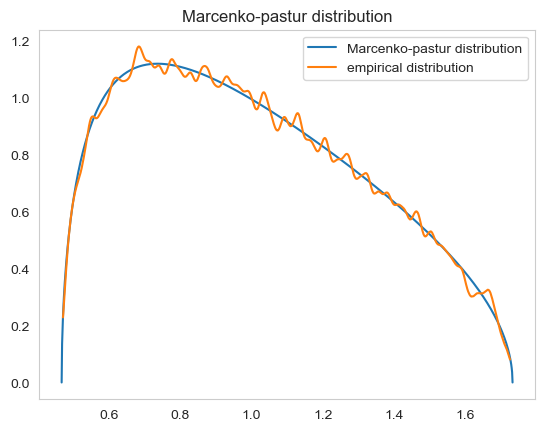

In [3]:
plt.plot(pdf0, label = 'Marcenko-pastur distribution')
plt.plot(pdf1, label = 'empirical distribution')
plt.legend()
plt.grid(False)
plt.title('Marcenko-pastur distribution')
plt.show()

#### 3. Random Matrix with Signal

경험적 상관 행렬에서 모든 고유 벡터가 랜덤하지 않을 수 있다 (사실 대부분의 경우에서 고유 벡터는 랜덤하지 않을 것이다)

대부분의 금융시장에서는 신호는 약하고, 잡음은 굉장이 클 것이다. 랜덤 공분산 행렬에 신호를 추가하여 비교해 보자

signal이 존재하는 랜덤 행렬에서의 marcenko-pastur 분포

In [4]:
def get_random_covariance(nCols, nFacts) :
    w = np.random.normal(size = (nCols, nFacts))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size = nCols))
    return cov

In [5]:
alpha = 0.995 # noise ratio
nCols = 1000
nFacts = 100
q = 10

cov = np.cov(
    np.random.normal(size = (nCols * q, nCols)),
    rowvar = 0
)
cov = alpha * cov + (1 - alpha) * get_random_covariance(nCols, nFacts) # noise + signal
corr0 = covariance_to_correlation(cov)
eVal0, eVec0 = getPCA(corr0)

신호가 있는 상태에서 marcenko-pastur dist 적합화를 진행하려면 다음과 같은 과정을 따라야 한다

In [6]:
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [7]:
pdf0 = marcenko_pastur_prob_distribution(
    var0, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

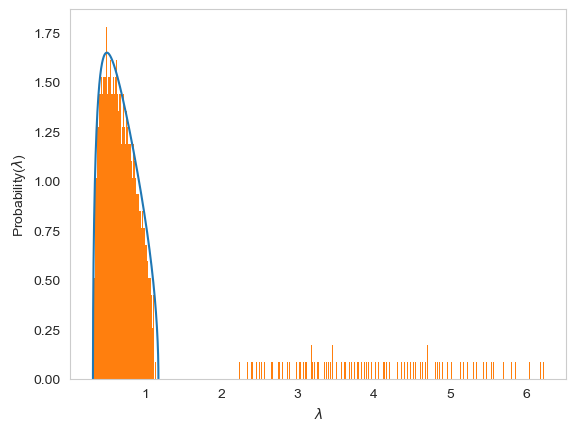

In [8]:
plt.plot(pdf0, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal0), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

#### 5. Denoising

empirical finance에서 대부분의 경우 공분산을 축소하여 사용하는 것이 일반적이다. 그러나 차원의 축소는 잡음 뿐만 아니라 신호 또한 구분하지 않고 조건의 수를 감소시킨다. 안그래도 약한 신호를 축소를 통해 더욱 약하게 만들 수도 있다

이번 절에서는 상관 행렬의 잡음 제거에 이 정보를 사용하는 방법에 대해 논한다

**5.1 Constant Residual Eigenvalue Method**

이 접근 방식은 모든 랜덤 고유 벡터에 대해 상수 고유값을 설정하는데에 있다. $\{\lambda_n\}_{n=1, \dots, N}$은 모든 고유값의 집합이며, 내림차순이며, $i$는 $\lambda_i > \lambda_+$와 $\lambda_{i+1} \leq \lambda_+$가 되는 고유값의 위치가 된다. 그런 다음 $\lambda_j = \frac{1}{N-i} \sum_{k = i+1}^N \lambda_k, j = i+1, \dots, N$을 설정해 상관 행렬의 대각합을 보존한다. 고유 벡터 분해 $VW = W\Lambda$가 주어질 때 다음과 같이 잡음이 제거된 상관행렬 $C_1$을 형성한다

$$\tilde C_1 = W \tilde\Lambda W^\prime$$
$$C_1 = \tilde C_1\Big[ \big(\mbox{diag}[\tilde C_1]\big)^\frac{1}{2}
\big(\mbox{diag}[\tilde C_1]\big)^{\frac{1}{2} \prime}\Big]^{-1}$$

상수 잔차 고유값을 이용한 잡음 제거

In [9]:
corr1 = denoise_constant_residual_eigenvalue(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

<Axes: >

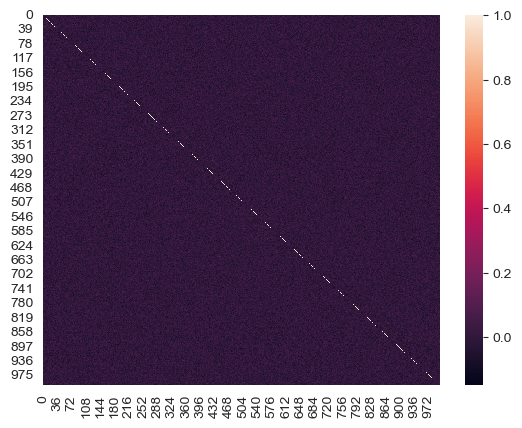

In [10]:
import seaborn as sns
sns.heatmap(corr1) # 상수 고유값 방법을 통한 잡음 제거

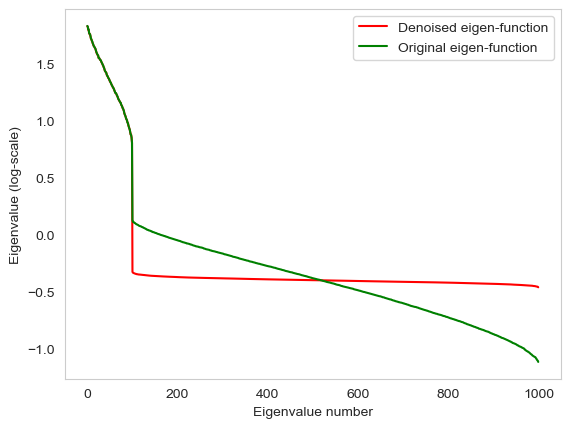

In [11]:
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.grid(False)
plt.show()

**5.2 Targeted Shrinkage**

5.1에서 설명한 수치적 방법은 신호를 보존하면서 잡음을 제거하기 때문에 축소보다는 선호된다. 대안적으로 랜덤 고유 벡터에 대해 엄격한 축소 적용을 목표로 할 수도 있다. 다음의 상관 행렬 $C_1$을 고려하자

$$C_1 = W_L\Lambda_L W_L^\prime + \alpha W_R \Lambda_R W_R^\prime + (1-\alpha) \mbox{diag}
[W_R \Lambda_R W_R^\prime]$$

여기서 $W_R$과 $\Lambda_R$은 $\{n|\lambda_n \leq \lambda_+\}$와 관련된 고유 벡터와 고유값이고, $W_L$과 $\Lambda_L$은 $\{n|\lambda_n > \lambda_+\}$와 관련된 고유 벡터와 고유값이며, $\alpha$는 잡음과 관련된 고유 벡터와 고유값 사이의 축소량을 조절한다

In [12]:
corr1 = denoise_target_shrinkage(eVal0, eVec0, nFacts0, alpha = 0.5)
eVal1, eVec1 = getPCA(corr1)

<Axes: >

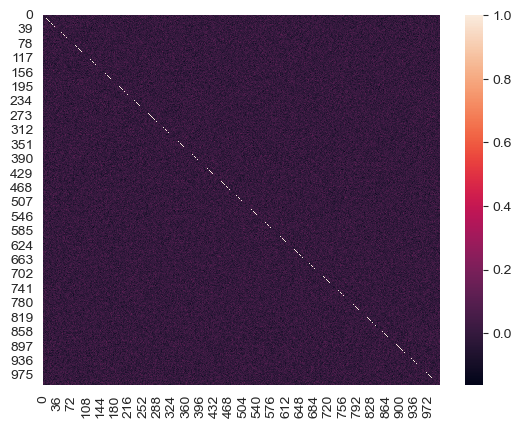

In [13]:
import seaborn as sns
sns.heatmap(corr1) # 타깃 축소를 이용한 잡음 제거

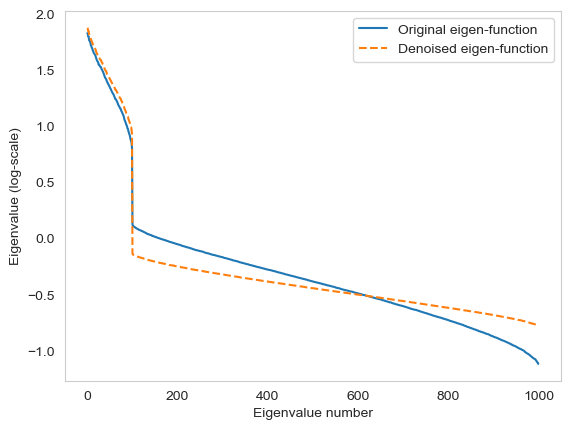

In [14]:
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), label="Original eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), label="Denoised eigen-function", ls = '--')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.grid(False)
plt.show()

#### 6. Detoning

금융 상관 행렬은 일반적으로 시장 요소를 포함한다. 시장 구성 요소는 로딩 $W_{n,1} \approx N^{\frac{1}{2}}, n=1,\dots, N$를 가진 첫 번째 고유 벡터로 특징된다. 따라서 시장 요소는 공분산 행렬의 모든 항목에 영향을 미친다

군집화 알고리즘 응용의 맥락에서 경우 시장 요소는 제거하는 것이 유용하다. 알고리즘이 군집 간 차이를 찾고자할 것이므로, 강력한 시장 구성 요소를 가진 상관 행렬을 군집화하는 것이 더 어렵기 때문이다

시장 요소를 제거하여 그 상관관계의 더 많은 부분을 유가증권의 특정 부분집합에 영향을미치는 요소들에 의해 설명될 수 있도록 한다. 잡음이 제거된 상관행렬 $C_1$에서 시장 요소를 제거해 주음 제거된 상관 행렬을 형성할 수 있다

$$
\tilde C_2 = C_1 - W_M \Lambda_M W_M^\prime = W_D \Lambda_D W_D^\prime
$$

$$
C_2 = \tilde C_2 \left[ 
\left( \mathrm{diag}[\tilde C_2] ^{\frac{1}{2}}\right)
\left( \mathrm{diag}[\tilde C_2] ^{\frac{1}{2}}^\prime\right)
\right]
$$

여기서 $W_M$과 $\Lambda_M$은 시장 요소와 관련된 고유 벡터 및 고유값이고, $W_D$와 $W\Lambda_D$는 비시장 요소와 관련된 고유 벡터 및 고유값이다. 주음 제거된 상관 행렬은 최소 1개의 고유 벡터를 제거한 결과로 특이 행렬이다

평균-분산 포트폴리오 최적화에 주음이 제거된 상관 행렬 $C_2$는 직접 사용할 수 없다. 대신에 선택된 주성분을 기반으로 포트폴리오를 최적화하고, 최적 배분 $f^*$를 원래 기저로 매핑할 수 있다. 원래 기저에서의 최적 배분은 다음과 같다

$$\omega ^* = W_+f^*$$

여기서 $W_+$는 주음 제거 프로세스에서 살아남은 고유 벡터만을 포함하며, $f^*$는 동일한 성분에 대한 최적 배분 벡터이다



In [15]:
corr_detoned_denoised = signal_detoning(corr0, eVal0, eVec0)

eVal1_detoned, eVec1_detoned = getPCA(corr_detoned_denoised)
detoned_eigenvalue = np.diag(eVal1_detoned)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_9771/587732260.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(range(0, len(detoned_eigenvalue)), np.log(detoned_eigenvalue), label="Detoned eigen-function")


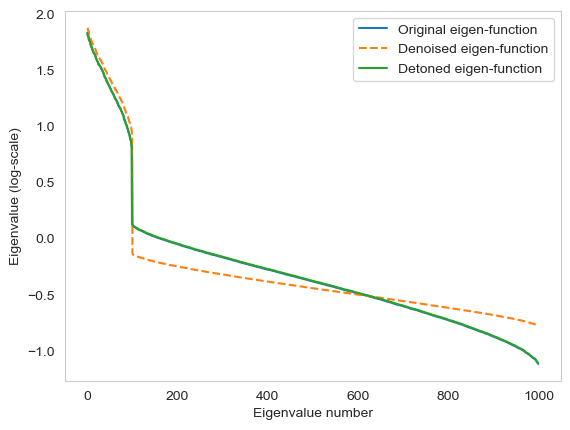

In [16]:
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), label="Original eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), label="Denoised eigen-function", ls = '--')
plt.plot(range(0, len(detoned_eigenvalue)), np.log(detoned_eigenvalue), label="Detoned eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.grid(False)
plt.show()

In [17]:
eMax1, var1 = find_max_eval(np.diag(eVal1_detoned), q, bWidth = 0.01)
nFacts1 = eVal1_detoned.shape[0] - np.diag(eVal1_detoned)[::-1].searchsorted(eMax1)

In [18]:
pdf1 = marcenko_pastur_prob_distribution(
    var1, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

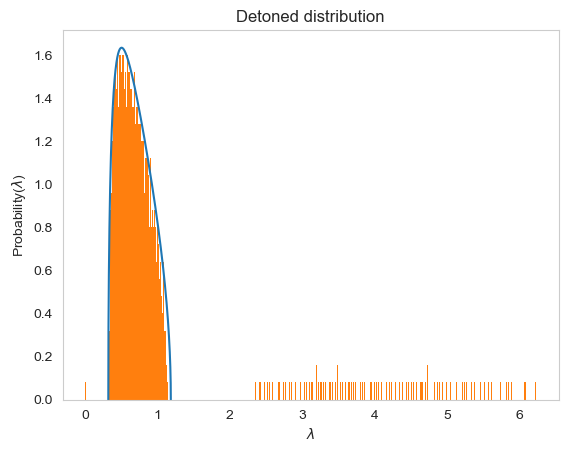

In [19]:
plt.plot(pdf1, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal1_detoned), density = True, bins = 500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.title("Detoned distribution")
plt.show()

### Montecarlo Simulation

몬테카를로 시뮬레이션을 통해 잡음 제거의 효과를 확인해 보자


#### Minimal Variacne Optimization Portfolio

In [20]:
from FinancialMachineLearning.generator.pca_blocks import *

In [21]:
from sklearn.covariance import LedoitWolf 
nBlocks, bSize, bCorr = 10, 50, .5
np.random.seed(42)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

In [22]:
def empirical_covariance_matrix(mu0, cov0, nObs, shrink = False): 
    x = np.random.multivariate_normal(mu0.flatten(),cov0,size = nObs) 
    mu1 = x.mean(axis = 0).reshape(-1,1)
    if shrink: cov1 = LedoitWolf().fit(x).covariance_ 
    else: cov1 = np.cov(x, rowvar = 0)
    return mu1,cov1

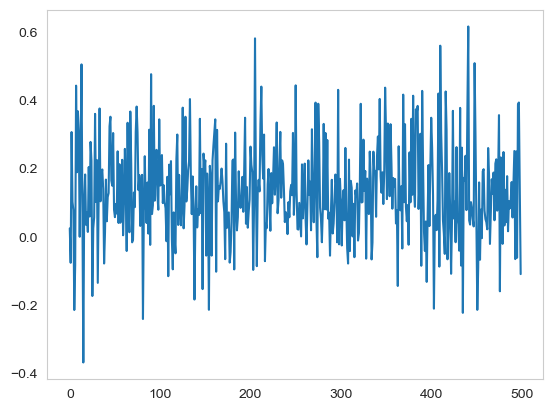

In [23]:
plt.plot(mu0)
plt.grid(False)
plt.show()

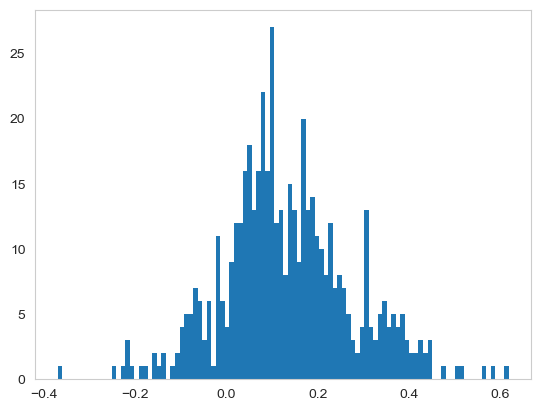

In [24]:
plt.hist(mu0, bins = 100, edgecolor = 'none')
plt.grid(False)
plt.show()

In [25]:
def deNoiseCov(cov0, q, bWidth):
    corr0 = covariance_to_correlation(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoise_constant_residual_eigenvalue(eVal0, eVec0, nFacts0)  # denoising by constant residual eigenvalue method
    cov1 = correlation_to_covariance(corr1, np.diag(cov0) ** .5)
    return cov1

In [26]:
nObs = 5
mu1, cov1 = empirical_covariance_matrix(mu0, cov0, nObs)

<Axes: >

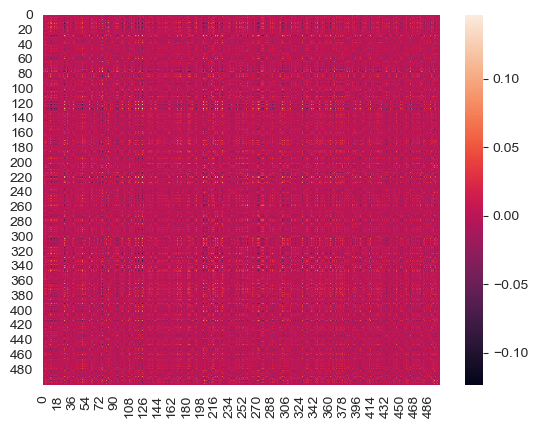

In [27]:
sns.heatmap(cov1)

<Axes: >

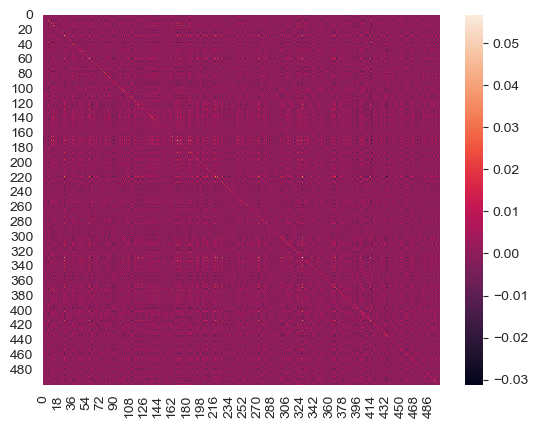

In [28]:
mu2, cov2 = empirical_covariance_matrix(mu0, cov0, nObs, shrink = True)
sns.heatmap(cov2) # Ledoit-Wolf shrinkage

Portfolio Optimization 

In [29]:
from tqdm import tqdm

In [30]:
nObs = 1000
nTrials = 100
bWidth = 0.01
shrink = False
minVarPortf = False

w1 = pd.DataFrame(
    columns = range(cov0.shape[0]), 
    index = range(nTrials),
    dtype = float
) 
w1_d = w1.copy(deep = True)
np.random.seed(42)
for i in tqdm(range(nTrials)):
    mu1, cov1 = empirical_covariance_matrix(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf: mu1 = None
    cov1_d = deNoiseCov(cov1, nObs * 1./cov1.shape[1], bWidth)
    w1.loc[i] = optimizing_portfolio(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = optimizing_portfolio(cov1_d, mu1).flatten()

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [31]:
w0 = optimizing_portfolio(cov0, None if minVarPortf else mu0) 
w0 = np.repeat(w0.T, w1.shape[0], axis = 0) 
rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** .5
rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** .5 # denoised
print(rmsd, rmsd_d)

0.46630277414397864 0.032167408953521576


In [32]:
minVarPortf = True

w1 = pd.DataFrame(
    columns = range(cov0.shape[0]), 
    index = range(nTrials), 
    dtype = float
) 
w1_d = w1.copy(deep = True)
np.random.seed(42)
for i in range(nTrials):
    mu1, cov1 = empirical_covariance_matrix(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf : mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optimizing_portfolio(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = optimizing_portfolio(cov1_d, mu1).flatten()

In [33]:
w0 = optimizing_portfolio(cov0, None if minVarPortf else mu0) 
w0 = np.repeat(w0.T, w1.shape[0],axis = 0) 
rmsd = np.mean((w1 - w0).values.flatten()**2)**.5
rmsd_d = np.mean((w1_d - w0).values.flatten()**2)**.5 # denoised
print(rmsd, rmsd_d)

0.005045849404333227 0.0011767403712115326


denoising된 포트폴리오의 RMSE가 현저히 낮은 것을 알 수 있다

### Empirical Data

실제 금융 데이터를 활용해 shrinkage가 현실적인지 확인한다

In [34]:
import warnings 
warnings.filterwarnings('ignore')

stock_list = pd.read_csv('stock_list.csv', index_col = 0)

In [35]:
code = stock_list['Code'][stock_list['Code'].str[-1] == '0'][:500]

In [36]:
import pandas_datareader as pdr
import datetime

data = pd.DataFrame()

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2024, 3, 7)

for i in code :
    data = pd.concat(
        [data, 
        pdr.DataReader(i, "naver", start_date, end_date)['Close']], 
        axis = 1
    )
data.columns = code

In [37]:
data.dropna(inplace = True, axis = 1)

In [38]:
data = data.astype(int)

<Axes: xlabel='Code', ylabel='Code'>

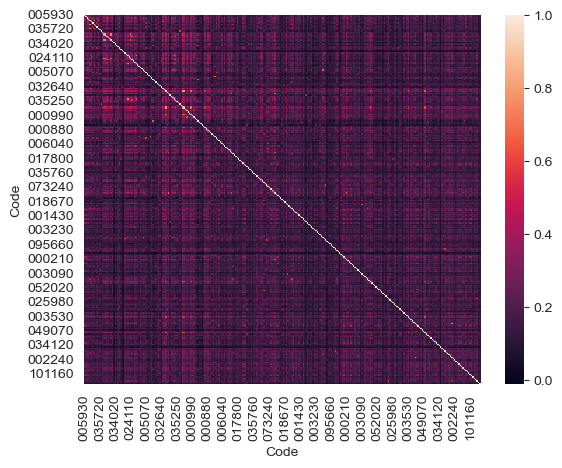

In [39]:
sns.heatmap(data.pct_change().corr())

In [40]:
eVal0, eVec0 = getPCA(data.pct_change().corr())

In [41]:
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [42]:
pdf0 = marcenko_pastur_prob_distribution(
    var0, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

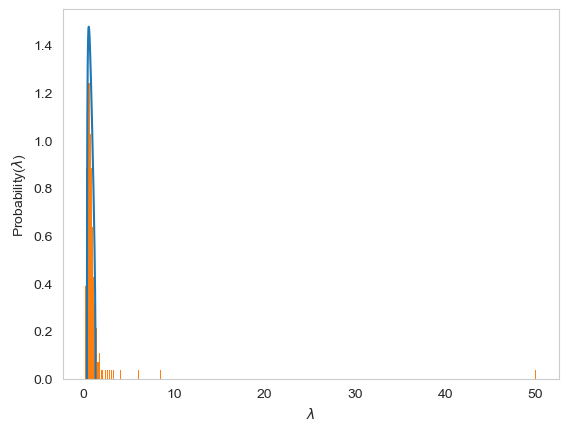

In [43]:
plt.plot(pdf0, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal0), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

In [44]:
corr1 = denoise_constant_residual_eigenvalue(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

In [45]:
eMax1, var1 = find_max_eval(np.diag(eVal1), q, bWidth = 0.01)
nFacts1 = eVal1.shape[0] - np.diag(eVal1)[::-1].searchsorted(eMax1)

In [46]:
pdf1 = marcenko_pastur_prob_distribution(
    var1, 
    q = x.shape[0] / float(x.shape[1]), 
    pts = 1000
)

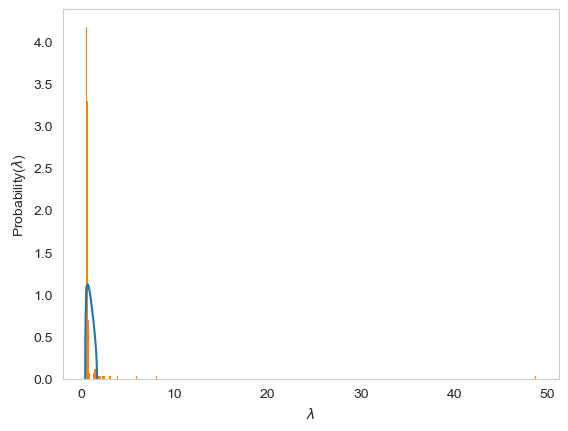

In [47]:
plt.plot(pdf1, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal1), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

<Axes: >

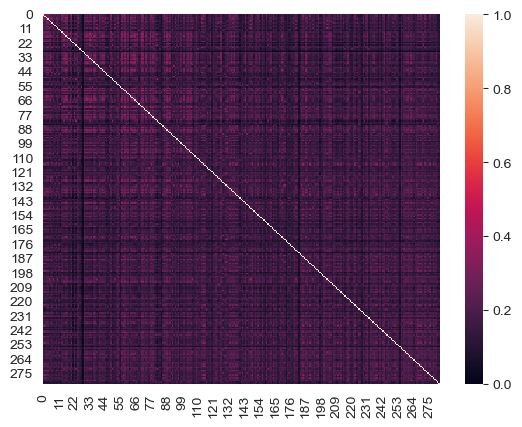

In [48]:
sns.heatmap(corr1)

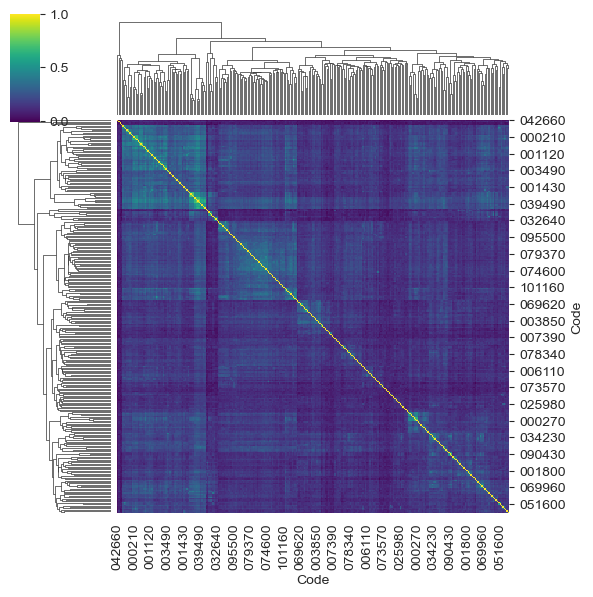

In [49]:
sns.clustermap(
    data.pct_change().corr(),
    figsize = (6, 6),
    cmap = 'viridis'
)

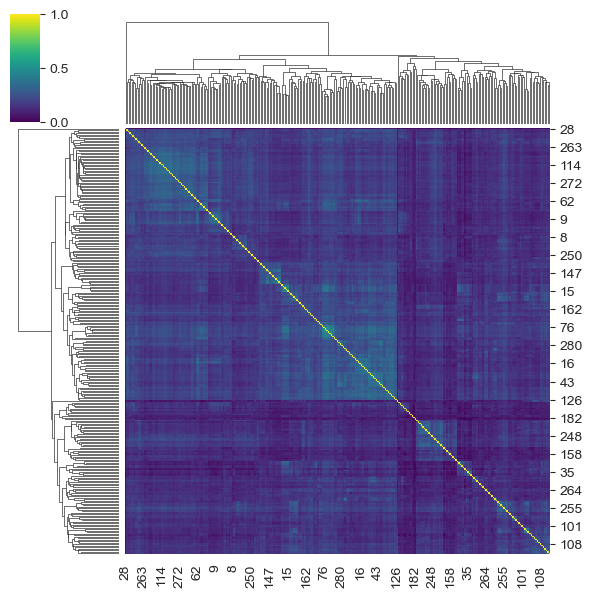

In [50]:
sns.clustermap(
    corr1,
    figsize = (6, 6),
    cmap = 'viridis'
)

In [51]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansBase, clusterKMeansTop

In [52]:
corr1 = pd.DataFrame(
    corr1,
    index = data.pct_change().corr().index,
    columns = data.pct_change().corr().columns
)

In [53]:
corr_kmeans, clusters_kmeans, silh_coef_kmeans = clusterKMeansBase(
    corr1, maxNumClusters = 10, n_init = 10
)

<Axes: xlabel='Code', ylabel='Code'>

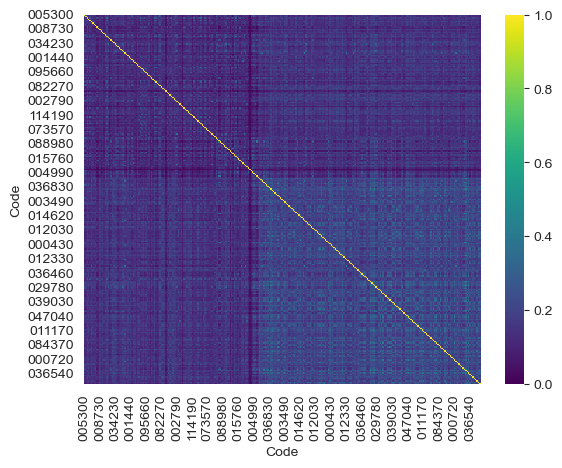

In [54]:
sns.heatmap(
    corr_kmeans,
    cmap = 'viridis'
)

In [55]:
origin_corr = data.pct_change().corr()

In [56]:
corr_kmean_origin, cluster, silh = clusterKMeansBase(
    origin_corr, maxNumClusters = 10, n_init = 10
)

<Axes: xlabel='Code', ylabel='Code'>

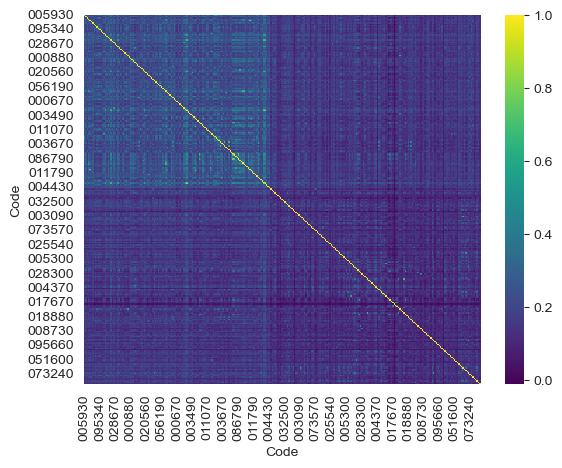

In [57]:
sns.heatmap(
    corr_kmean_origin,
    cmap = 'viridis'
)

In [58]:
corr_kmean_top, clusters_kmean_top, silh_coef_kmean_top = clusterKMeansTop(
    corr1, maxNumClusters = 10, n_init = 10
)

clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[0] clstrs len:2
